OSEMN

1.Obtain
2.Scrub
3.Explore

# 1. Obtain - Data Collection
we did web scraping specific property sale data from Mudah website using Octoparse, targeting Johor properties with details like price, size, bedrooms, location, and available amenities.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from joblib import dump
from joblib import load


Loading and Displaying the First Few Rows of the Dataset

In [ ]:
df = pd.read_csv('/content/drive/My Drive/JB PROP PREDICT DATASET.csv')
df.head()

,URL,Property Type,Property_description,peoperty_Size,property_Price,No.of_Bedrooms,No.of_Bathroom,Location,No.of Floors,Land Title,...,Minimart facility,gymnasium facility,Multipurpose hall facility,club house facility,Tennis Court facility,Squash court facility,Sauna facility,Date posted,Unnamed: 27,Unnamed: 28
0,https://www.mudah.my/taman-makmur-jalan-makmur...,House,2-storey Terraced House,770 sq.ft.,"RM 300,000",3 Bedrooms,1 Bathroom,Kulai,NaN,Non Bumi Lot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16-11-2024,NaN,NaN
1,https://www.mudah.my/full-loan-tampoi-lily-jas...,Apartment / Condominium,Apartment,1001 sq.ft.,"RM 260,000",3 Bedrooms,2 Bathrooms,Johor Bahru,4.0,Non Bumi Lot,...,Minimart,NaN,NaN,NaN,NaN,NaN,NaN,16-11-2024,NaN,NaN
2,https://www.mudah.my/mount-austin-flat-3-bedro...,Apartment / Condominium,Flat,750 sq.ft.,"RM 220,000",3 Bedrooms,1 Bathroom,Johor Bahru,5.0,Non Bumi Lot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16-11-2024,NaN,NaN
3,https://www.mudah.my/2-storey-terrace-house-bu...,House,2-storey Terraced House,1400 sq.ft.,"RM 830,000",4 Bedrooms,4 Bathrooms,Iskandar Puteri,NaN,Non Bumi Lot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16-11-2024,NaN,NaN
4,https://www.mudah.my/easy-ciq-sierra-perdana-2...,House,2-storey Terraced House,1300 sq.ft.,"RM 540,000",4 Bedrooms,3 Bathrooms,Permas Jaya,NaN,Non Bumi Lot,...,Minimart,NaN,NaN,NaN,NaN,NaN,NaN,16-11-2024,NaN,NaN


#2. Scrub- Data Cleaning

Checking for Missing Values in the Dataset

In [ ]:
df.isnull().sum()

,0
URL,5
Property Type,0
Property_description,51
peoperty_Size,0
property_Price,5
No.of_Bedrooms,1
No.of_Bathroom,1
Location,0
No.of Floors,4092
Land Title,41


Checking the Shape of the Dataset

In [ ]:
df.shape

(4840, 29)

In [ ]:
columns_to_check = ['URL', 'Property_description', 'property_Price', 'No.of_Bedrooms', 'No.of_Bathroom', 'Land Title']
df = df.dropna(subset=columns_to_check)
df.columns = df.columns.str.replace('.', '_', regex=False)
# Explicitly make a copy of the DataFrame
df = df.copy()
# Perform the renaming safely
df.rename(columns={'Location ': 'Location', 'Date posted ': 'Date posted'}, inplace=True)

Checking for Duplicate Values in the Dataset

In [ ]:
df.duplicated().sum()

0

Ensure Consistency in Data Formats

In [ ]:
df.columns

Index(['URL', 'Property Type', 'Property_description', 'peoperty_Size',
       'property_Price', 'No_of_Bedrooms', 'No_of_Bathroom', 'Location',
       'No_of Floors', 'Land Title', 'Parking Facility', 'Internet Facility',
       'Security facility', 'Playground facility', 'swimming pool facility',
       'BBQ Area facility', 'Jogging Track facility', 'Unnamed: 17',
       'Lift facility', 'Minimart facility', 'gymnasium facility',
       'Multipurpose hall facility', 'club house facility',
       'Tennis Court facility', 'Squash court facility', 'Sauna facility',
       'Date posted', 'Unnamed: 27', 'Unnamed: 28'],
      dtype='object')

In [ ]:
df['Price'] = [int(str(value).replace('RM', '').replace(',', '').strip()) if not isinstance(value, int) else value for value in df['property_Price']]
df[['Price','property_Price']]

,Price,property_Price
0,300000,"RM 300,000"
1,260000,"RM 260,000"
2,220000,"RM 220,000"
3,830000,"RM 830,000"
4,540000,"RM 540,000"
...,...,...
4835,618000,"RM 618,000"
4836,435000,"RM 435,000"
4837,298000,"RM 298,000"
4838,370000,"RM 370,000"


In [ ]:
def convert_to_sqft(value):
  try:
        if isinstance(value, str):
            if 'Acres' in value:
                acres = float(value.split(' ')[0])
                return int(acres * 43560)
            elif 'sq.ft.' in value:
                return int(value.split(' ')[0])
        return None
  except Exception:
        return None

df['Size'] = df['peoperty_Size'].apply(convert_to_sqft)
df[['Size', 'peoperty_Size']]

,Size,peoperty_Size
0,770,770 sq.ft.
1,1001,1001 sq.ft.
2,750,750 sq.ft.
3,1400,1400 sq.ft.
4,1300,1300 sq.ft.
...,...,...
4835,770,770 sq.ft.
4836,2874,2874 sq.ft.
4837,770,770 sq.ft.
4838,1330,1330 sq.ft.


In [ ]:
df.No_of_Bedrooms.unique()

array(['3 Bedrooms', '4 Bedrooms', 'Freehold', 'Leasehold', '2 Bedrooms',
       '6 Bedrooms', '5 Bedrooms', '1 Bedroom', 'More than 10 Bedroom',
       '8 Bedrooms', '7 Bedrooms', '10 Bedrooms', '9 Bedrooms'],
      dtype=object)

In [ ]:
sum(df.No_of_Bedrooms == 'Freehold')

433

In [ ]:
sum(df.No_of_Bedrooms == 'More than 10 Bedroom')

5

In [ ]:
df.No_of_Bathroom.unique()

array(['1 Bathroom', '2 Bathrooms', '4 Bathrooms', '3 Bathrooms',
       'Shop lot', 'Agricultural', 'Warehouse / Factory', '5 Bathrooms',
       'Residential', 'Commercial', 'Industrial', 'Others', '6 Bathrooms',
       'Office space', 'Hotel / Resort', '9 Bathrooms', '7 Bathrooms',
       'Mixed Development', '8 Bathrooms', 'Retail space',
       'More than 10 Bathroom'], dtype=object)

In [ ]:
Bacategories = [
    'Agricultural', 'Commercial', 'Hotel / Resort', 'Industrial',
    'Mixed Development', 'More than 10 Bathroom', 'Office space',
    'Others', 'Residential', 'Retail space', 'Shop lot', 'Warehouse / Factory'
]
df.No_of_Bathroom.isin(Bacategories).sum()

503

In [ ]:
df['No_of_Bedrooms'] = df['No_of_Bedrooms'].astype(str)
df['No_of_Bedrooms'] = df['No_of_Bedrooms'].replace(['', ' '], pd.NA)
df = df[~df['No_of_Bedrooms'].str.contains('Freehold|Leasehold|More than 10 Bedroom', na=False)].copy()
df['No_of_Bathroom'] = df['No_of_Bathroom'].astype(str)
df['No_of_Bathroom'] = df['No_of_Bathroom'].replace(['', ' '], pd.NA)
df = df[~df['No_of_Bathroom'].isin(Bacategories)].copy()

In [ ]:
df['bdm'] = df['No_of_Bedrooms'].apply(lambda x: int(x.split(' ')[0]))
df['btm'] = df['No_of_Bathroom'].apply(lambda x: int(x.split(' ')[0]))
df[['No_of_Bedrooms','bdm','No_of_Bathroom','btm']]

,No_of_Bedrooms,bdm,No_of_Bathroom,btm
0,3 Bedrooms,3,1 Bathroom,1
1,3 Bedrooms,3,2 Bathrooms,2
2,3 Bedrooms,3,1 Bathroom,1
3,4 Bedrooms,4,4 Bathrooms,4
4,4 Bedrooms,4,3 Bathrooms,3
...,...,...,...,...
4835,3 Bedrooms,3,2 Bathrooms,2
4836,4 Bedrooms,4,2 Bathrooms,2
4837,3 Bedrooms,3,2 Bathrooms,2
4838,4 Bedrooms,4,3 Bathrooms,3


Checking for Outliers in the Dataset  

In [ ]:
df_selected = df[['Price', 'Size']]


def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df < lower_bound) | (df > upper_bound)

outliers = detect_outliers_iqr(df_selected)

outlier_rows = df[outliers.any(axis=1)]

Handle Outliers

In [ ]:
df = df[~outliers.any(axis=1)]

In [ ]:
df.shape

(3753, 33)

In [ ]:
df.head()

,URL,Property Type,Property_description,peoperty_Size,property_Price,No_of_Bedrooms,No_of_Bathroom,Location,No_of Floors,Land Title,...,Tennis Court facility,Squash court facility,Sauna facility,Date posted,Unnamed: 27,Unnamed: 28,Price,Size,bdm,btm
0,https://www.mudah.my/taman-makmur-jalan-makmur...,House,2-storey Terraced House,770 sq.ft.,"RM 300,000",3 Bedrooms,1 Bathroom,Kulai,NaN,Non Bumi Lot,...,NaN,NaN,NaN,16-11-2024,NaN,NaN,300000,770,3,1
1,https://www.mudah.my/full-loan-tampoi-lily-jas...,Apartment / Condominium,Apartment,1001 sq.ft.,"RM 260,000",3 Bedrooms,2 Bathrooms,Johor Bahru,4.0,Non Bumi Lot,...,NaN,NaN,NaN,16-11-2024,NaN,NaN,260000,1001,3,2
2,https://www.mudah.my/mount-austin-flat-3-bedro...,Apartment / Condominium,Flat,750 sq.ft.,"RM 220,000",3 Bedrooms,1 Bathroom,Johor Bahru,5.0,Non Bumi Lot,...,NaN,NaN,NaN,16-11-2024,NaN,NaN,220000,750,3,1
3,https://www.mudah.my/2-storey-terrace-house-bu...,House,2-storey Terraced House,1400 sq.ft.,"RM 830,000",4 Bedrooms,4 Bathrooms,Iskandar Puteri,NaN,Non Bumi Lot,...,NaN,NaN,NaN,16-11-2024,NaN,NaN,830000,1400,4,4
4,https://www.mudah.my/easy-ciq-sierra-perdana-2...,House,2-storey Terraced House,1300 sq.ft.,"RM 540,000",4 Bedrooms,3 Bathrooms,Permas Jaya,NaN,Non Bumi Lot,...,NaN,NaN,NaN,16-11-2024,NaN,NaN,540000,1300,4,3


Remove Irrelevant Data

In [ ]:
df2 = df.drop(['property_Price', 'peoperty_Size', 'No_of_Bedrooms', 'No_of_Bathroom', 'URL', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 17', 'No_of Floors', 'Date posted'], axis=1)

Divide location

In [ ]:
location_stats = df2['Location'].value_counts(ascending=False)
location_stats_less_than_10 = location_stats[location_stats <= 10]
df2.Location = df2.Location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
location_stats

,count
Location,
Johor Bahru,1088
Skudai,603
Pasir Gudang,381
Masai,288
Kulai,275
Iskandar Puteri,199
Ulu Tiram,163
Kluang,112
Gelang Patah,106


3.Explore-Find significant patterns and trends using statistical methods

Handle Categorical Variables ---One-Hot Encoding

In [ ]:
columns_to_encode = [
    'Property Type', 'Property_description', 'Land Title', 'Location',
    'Parking Facility', 'Internet Facility', 'Security facility',
    'Playground facility', 'swimming pool facility', 'BBQ Area facility',
    'Jogging Track facility', 'Lift facility', 'Minimart facility',
    'gymnasium facility', 'Multipurpose hall facility', 'club house facility',
    'Tennis Court facility', 'Squash court facility', 'Sauna facility'
]

df3 = pd.get_dummies(df2, columns=columns_to_encode, prefix=columns_to_encode)
df3.head()
output_csv = '/content/drive/My Drive/1.csv'
df3.to_csv(output_csv, index=False)

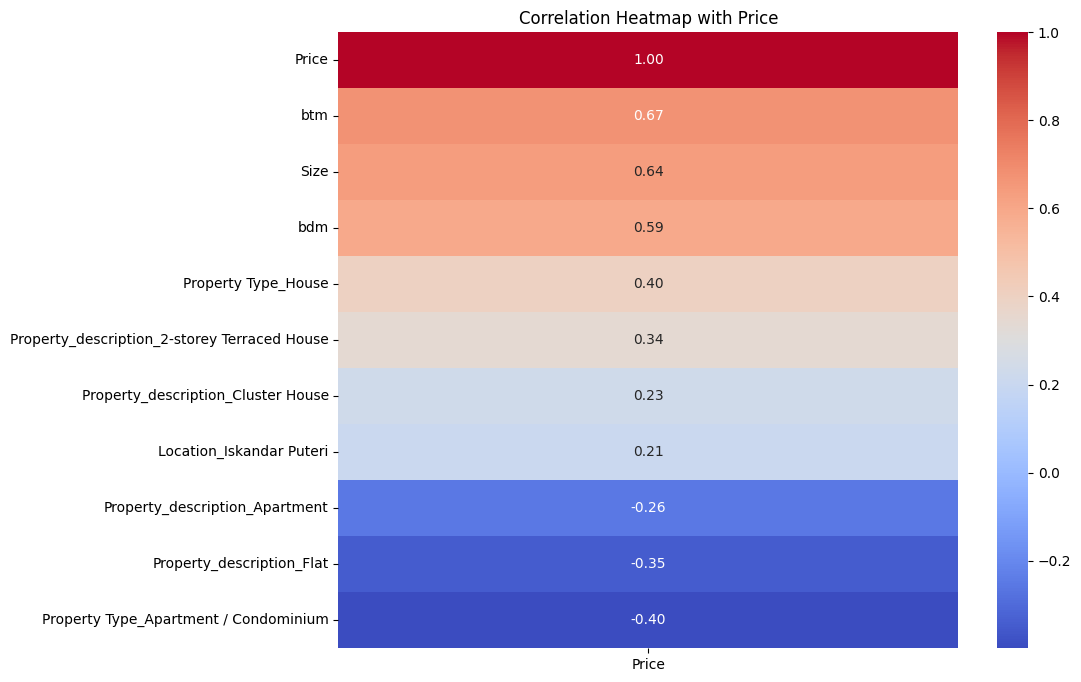

In [ ]:
import seaborn as sns

target = 'Price'

correlation_matrix = df3.corr()

target_corr = correlation_matrix[[target]].sort_values(by=target, ascending=False)

threshold = 0.2
filtered_target_corr = target_corr[abs(target_corr[target]) > threshold]

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_target_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap with {target}")
plt.show()

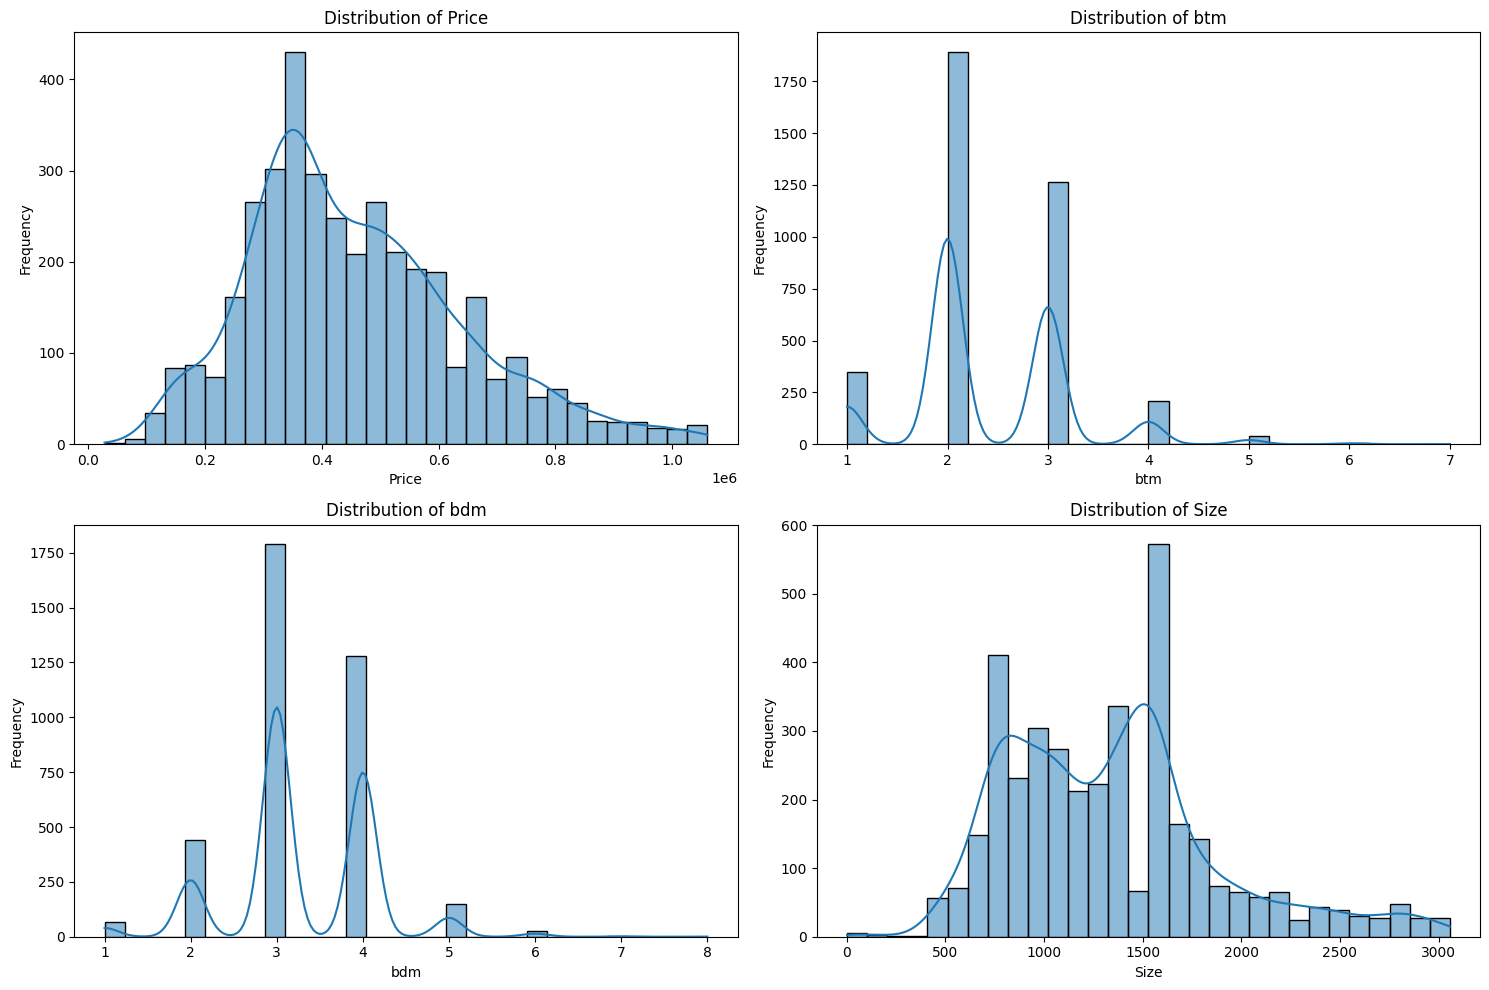

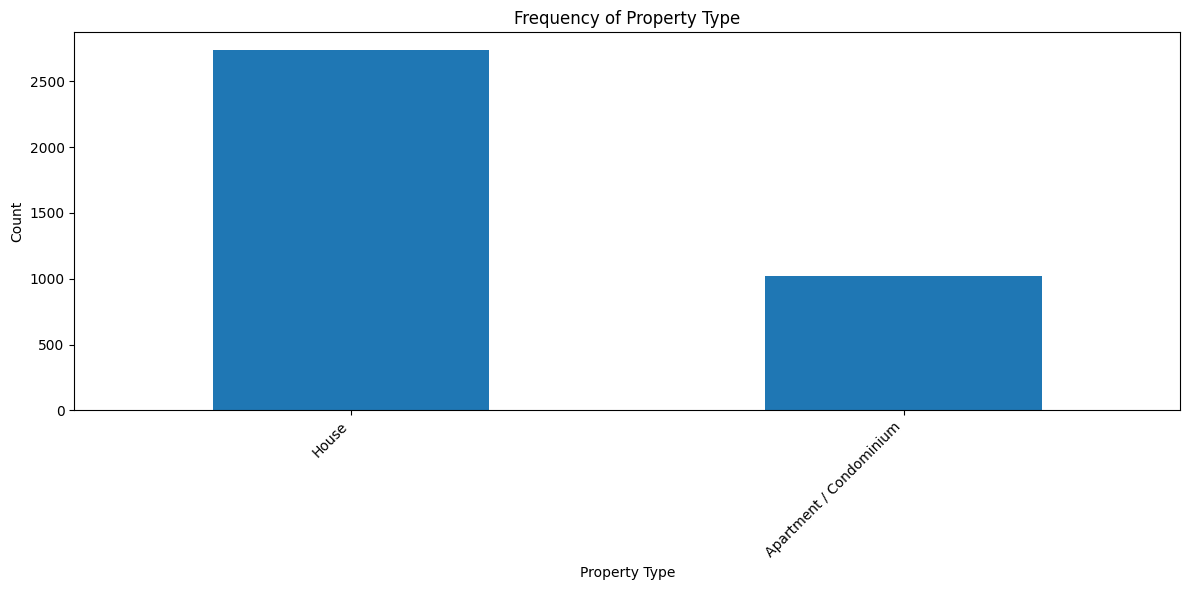

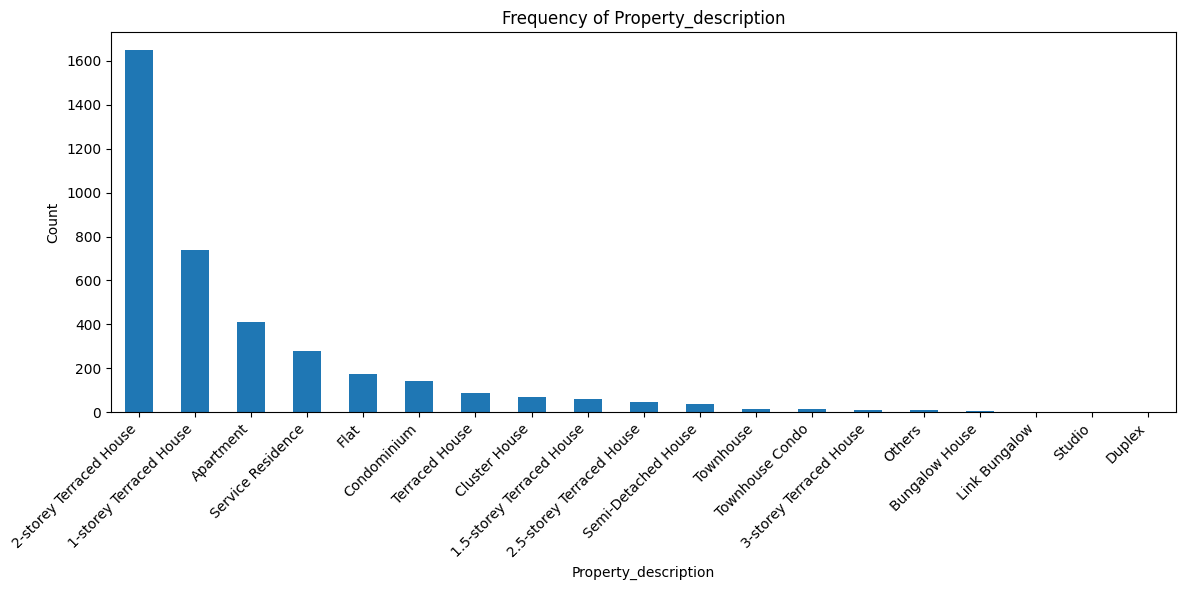

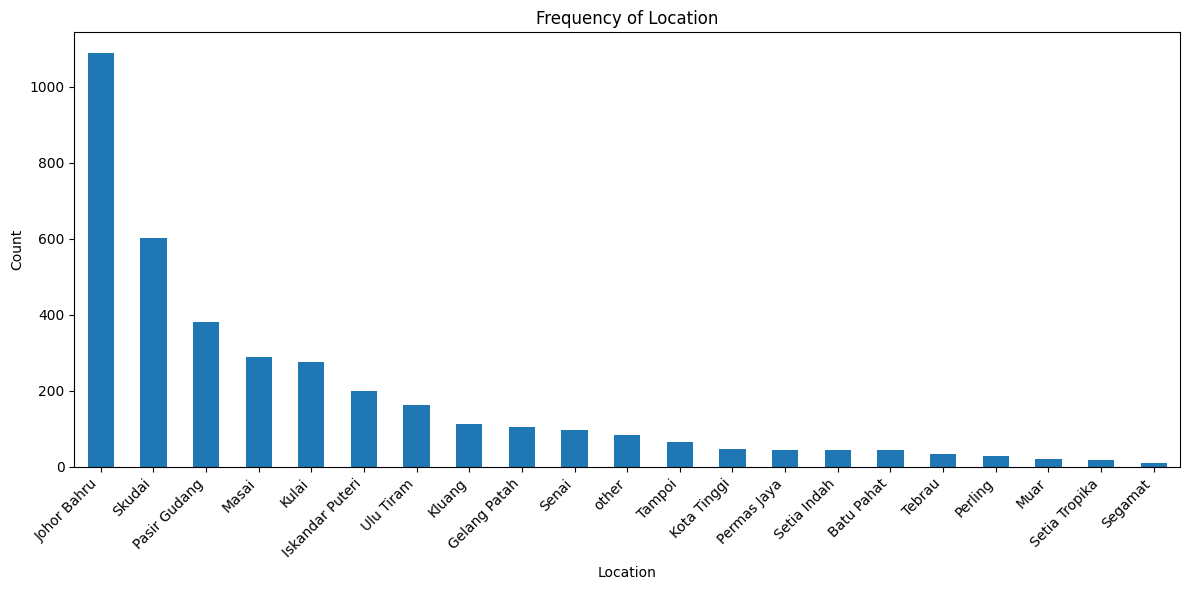

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设您已有 df2 数据
# 选取需要的列
columns_to_plot = ['Price', 'btm', 'bdm', 'Size', 'Property Type', 'Property_description', 'Location']
df_selected = df2[columns_to_plot]

# 设置画布大小
plt.figure(figsize=(15, 10))

# 绘制数值型数据的直方图
numeric_columns = ['Price', 'btm', 'bdm', 'Size']
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)  # 创建子图
    sns.histplot(df_selected[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 绘制分类型数据的条形图
categorical_columns = ['Property Type', 'Property_description', 'Location']
for col in categorical_columns:
    plt.figure(figsize=(12, 6))  # 调整画布大小
    df_selected[col].value_counts().plot(kind='bar')
    plt.title(f"Frequency of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')  # 旋转标签并右对齐
    plt.tight_layout()  # 自动调整布局避免重叠
    plt.show()


Feature Selection

After feature selection, the square of r decreased from 0.82 to 0.8, but the model was simpler, easier to interpret, and faster to train after dimensionality reduction.we keep the 'Price', 'btm', 'bdm', 'Size', 'Property Type','Property_description','Location'

In [ ]:

columns_to_keep = ['Price', 'btm', 'bdm', 'Size']

property_type_cols = [col for col in df3.columns if col.startswith('Property Type')]
property_description_cols = [col for col in df3.columns if col.startswith('Property_description')]


location_cols = [col for col in df3.columns if col.startswith('Location')]


final_columns = columns_to_keep + property_type_cols + property_description_cols + location_cols


df3 = df3[final_columns]
df3.head()


,Price,btm,bdm,Size,Property Type_Apartment / Condominium,Property Type_House,Property_description_1-storey Terraced House,Property_description_1.5-storey Terraced House,Property_description_2-storey Terraced House,Property_description_2.5-storey Terraced House,...,Location_Permas Jaya,Location_Segamat,Location_Senai,Location_Setia Indah,Location_Setia Tropika,Location_Skudai,Location_Tampoi,Location_Tebrau,Location_Ulu Tiram,Location_other
0,300000,1,3,770,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,260000,2,3,1001,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,220000,1,3,750,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,830000,4,4,1400,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,540000,3,4,1300,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
X = df3.drop(columns=['Price'])
y = df3['Price']  # Target: House Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modol-Construct the models to predict and forecast

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

base_price_pred = linear_model.predict(X_test)

mse = mean_squared_error(y_test, base_price_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, base_price_pred)
mae = mean_absolute_error(y_test, base_price_pred)
medae = mean_absolute_error(y_test, base_price_pred)

# Create a table of evaluation metrics
metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R² (Coefficient of Determination)',
               'Mean Absolute Error (MAE)', 'Median Absolute Error (MedAE)'],
    'Score': [mse, rmse, r2, mae, medae]
}

metrics_df = pd.DataFrame(metrics)

# Print the evaluation metrics table
print(metrics_df)


                              Metric         Score
0           Mean Squared Error (MSE)  8.908411e+09
1     Root Mean Squared Error (RMSE)  9.438438e+04
2  R² (Coefficient of Determination)  7.494391e-01
3          Mean Absolute Error (MAE)  6.954344e+04
4      Median Absolute Error (MedAE)  6.954344e+04


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV with K-fold Cross Validation (5-fold)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    scoring='neg_mean_squared_error'
)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters from the search
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

best_rf = random_search.best_estimator_

base_price_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, base_price_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, base_price_pred)
mae = mean_absolute_error(y_test, base_price_pred)
medae = mean_absolute_error(y_test, base_price_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R² (Coefficient of Determination)',
               'Mean Absolute Error (MAE)', 'Median Absolute Error (MedAE)'],
    'Score': [mse, rmse, r2, mae, medae]
}

metrics_df = pd.DataFrame(metrics)

# Print the evaluation metrics table
print(metrics_df)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Mean Squared Error (MSE): 7465892499.536383
Root Mean Squared Error (RMSE): 86405.39624083893
R² (Coefficient of Determination): 0.7900118428704547
                              Metric         Score
0           Mean Squared Error (MSE)  7.465892e+09
1     Root Mean Squared Error (RMSE)  8.640540e+04
2  R² (Coefficient of Determination)  7.900118e-01
3          Mean Absolute Error (MAE)  5.704334e+04
4      Median Absolute Error (MedAE)  5.704334e+04


In [ ]:
!pip install scikit-learn==1.0.2

In [ ]:
from xgboost import XGBRegressor

# Define parameter distribution for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of boosting rounds
    'max_depth': [3, 5, 10, 20],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns for each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization term
    'reg_lambda': [1, 1.5, 2, 3],  # L2 regularization term
}

# Initialize the XGBoost model
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# Perform RandomizedSearchCV with K-fold Cross Validation (5-fold)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    scoring='neg_mean_squared_error'
)

# Split data into training and testing sets (replace X, y with your dataset)
# Example: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters from the search
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Use the best estimator to make predictions
best_xgb = random_search.best_estimator_
base_price_pred = best_xgb.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, base_price_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, base_price_pred)
mae = mean_absolute_error(y_test, base_price_pred)
medae = mean_absolute_error(y_test, base_price_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R² (Coefficient of Determination)',
               'Mean Absolute Error (MAE)', 'Median Absolute Error (MedAE)'],
    'Score': [mse, rmse, r2, mae, medae]
}

metrics_df = pd.DataFrame(metrics)

# Print the evaluation metrics table
print(metrics_df)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Mean Squared Error (MSE): 7106247926.622355
Root Mean Squared Error (RMSE): 84298.56420261471
R² (Coefficient of Determination): 0.8001273248563725
                              Metric         Score
0           Mean Squared Error (MSE)  7.106248e+09
1     Root Mean Squared Error (RMSE)  8.429856e+04
2  R² (Coefficient of Determination)  8.001273e-01
3          Mean Absolute Error (MAE)  5.908852e+04
4      Median Absolute Error (MedAE)  5.908852e+04


In [ ]:
!pip install scikit-learn==1.0.2


In [ ]:
from joblib import dump

# Save the best XGBoost model to a file
output_path = '/content/drive/My Drive/best_xgb_model.joblib'
dump(best_xgb, output_path)

['/content/drive/My Drive/best_xgb_model.joblib']

Interpret-Put the result into good use










 'btm', 'bdm', 'Size', 'Property Type','Property_description','Location'

In [ ]:
# Load the model
best_xgb = load(output_path)

# Step 1: Prepare raw data with the same categorical and numerical features
raw_new_data = pd.DataFrame({
    'Size': [1000],  # House size in square feet
    'Location': ['Johor Bahru'],  # Categorical feature for location
    'bdm': [2],  # Number of bedrooms
    'btm': [3],  # Number of bathrooms
    'Property Type': ['Apartment / Condominium'],  # Categorical feature for property type
    'Property_description': ['Cluster House'],  # Categorical feature for property description
})

# Step 2: One-hot encode categorical features
new_data_encoded = pd.get_dummies(raw_new_data, columns=['Location', 'Property Type', 'Property_description'])

# Step 3: Ensure consistency with training columns (df3)
# Identify missing columns and add them with 0 values
missing_cols = set(df3.columns) - set(new_data_encoded.columns)
for col in missing_cols:
    new_data_encoded[col] = 0  # Add missing columns with 0 values

# Drop any extra columns not in df3
extra_cols = set(new_data_encoded.columns) - set(df3.columns)
new_data_encoded = new_data_encoded.drop(extra_cols, axis=1)

# Reorder columns to match the training DataFrame (df3)
new_data_encoded = new_data_encoded[final_columns[1:]]  # Exclude 'Price' since it's the target

# Step 4: Predict the price using the trained model
predicted_price = best_xgb.predict(new_data_encoded)

# Step 5: Output the predicted price
print(f"Predicted House Price: {predicted_price[0]:,.2f}")


Predicted House Price: 435,812.72


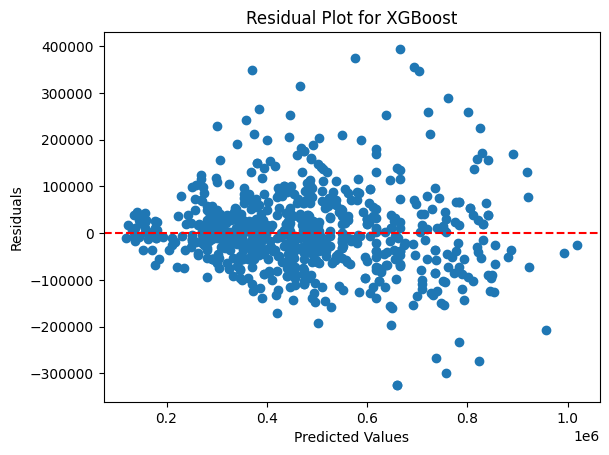

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - base_price_pred

# Plot residuals
plt.scatter(base_price_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for XGBoost')
plt.show()


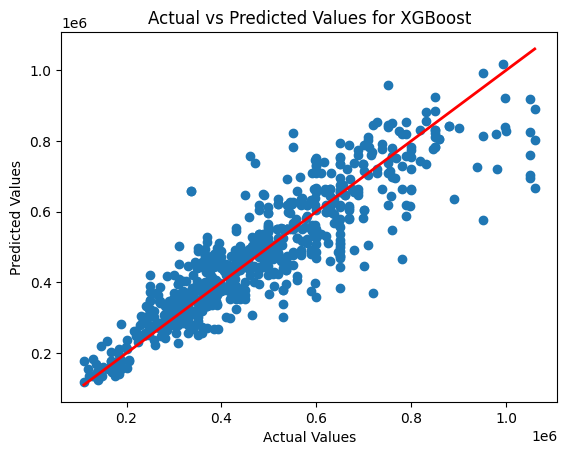

In [ ]:
# Plot Actual vs Predicted
plt.scatter(y_test, base_price_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Perfect fit line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for XGBoost')
plt.show()


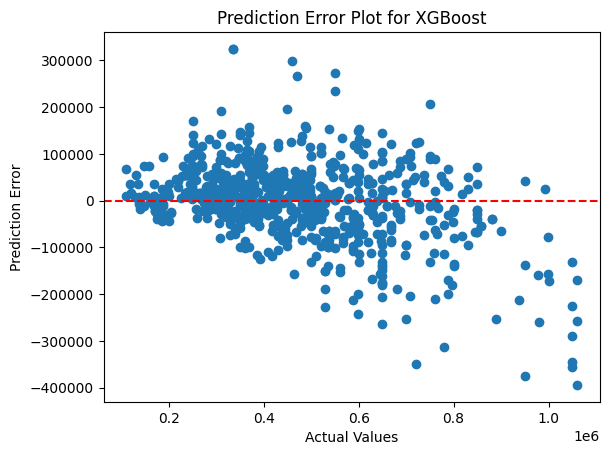

In [ ]:
# Calculate prediction errors
errors = base_price_pred - y_test

# Plot prediction errors
plt.scatter(y_test, errors)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Prediction Error')
plt.title('Prediction Error Plot for XGBoost')
plt.show()


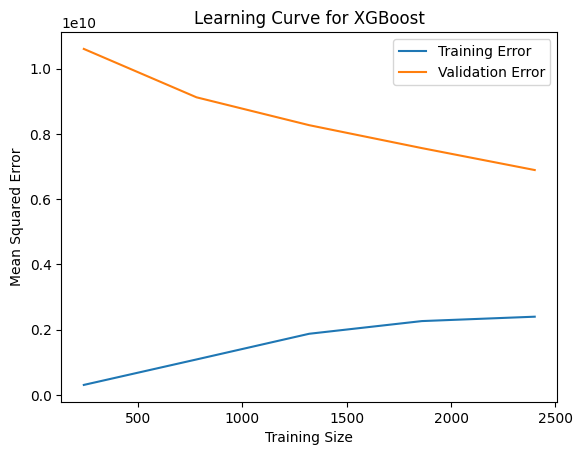

In [ ]:
from sklearn.model_selection import learning_curve

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    XGBRegressor(random_state=42, objective='reg:squarederror'), X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Plot the learning curve
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation Error')
plt.xlabel('Training Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve for XGBoost')
plt.legend()
plt.show()


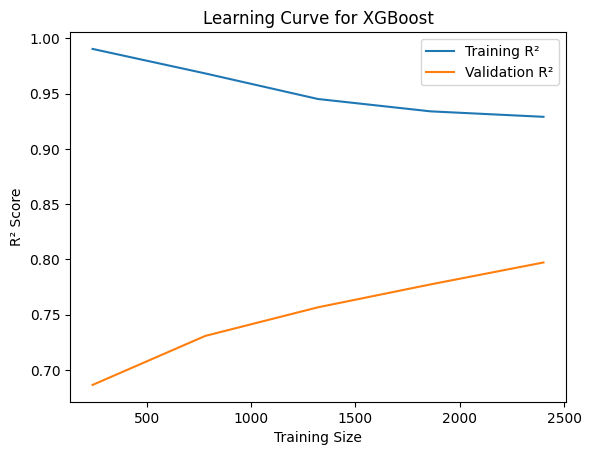

In [ ]:
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Calculate learning curve with R^2
train_sizes, train_scores, test_scores = learning_curve(
    XGBRegressor(random_state=42, objective='reg:squarederror'),
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

# Plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training R²')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation R²')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title('Learning Curve for XGBoost')
plt.legend()
plt.show()


In [ ]:

file_name = '/content/drive/My Drive/Jadual Penerbitan IHRM Q1 2024P.xlsx'
data = pd.read_excel(file_name, sheet_name='TABLE I', skiprows=3)
data.columns = ['State', '2019_Q2', '2019_Q3', '2019_Q4', '2020_Q1', '2020_Q2', '2020_Q3',
                '2020_Q4', '2021_Q1', '2021_Q2', '2021_Q3', '2021_Q4', '2022_Q1', '2022_Q2',
                '2022_Q3', '2022_Q4', '2023_Q1', '2023_Q2', '2023_Q3', '2023_Q4', '2024_Q1P']
start_row_index = data[data['State'] == 'Annual House Price Change (% Change Over 12 Months)'].index[0] + 1

annual_house_price_data = data.iloc[start_row_index:].reset_index(drop=True)

annual_house_price_data = annual_house_price_data.dropna(subset=['State'])
annual_house_price_data = annual_house_price_data.iloc[:-1]
annual_house_price_data

,State,2019_Q2,2019_Q3,2019_Q4,2020_Q1,2020_Q2,2020_Q3,2020_Q4,2021_Q1,2021_Q2,...,2021_Q4,2022_Q1,2022_Q2,2022_Q3,2022_Q4,2023_Q1,2023_Q2,2023_Q3,2023_Q4,2024_Q1P
1,Malaysia,2.330399,2.150538,1.792115,1.887755,1.417004,0.200501,1.207243,0.701052,1.047904,...,1.888668,2.386872,2.617284,5.148515,3.902439,4.808159,4.331088,3.295669,3.849765,0.509731
2,Kuala Lumpur,-0.805639,0.201918,-1.158107,-0.701052,0.406091,-1.460957,-1.018849,-3.630862,-3.64004,...,-0.720535,0.418629,0.472193,2.116402,0.673924,2.657634,3.498695,2.694301,2.677652,-0.964467
3,Selangor,2.020202,1.895262,2.011061,1.104972,0,-1.517376,0,1.241927,1.930693,...,3.696402,3.140334,3.01117,6.082725,3.469582,4.614653,3.960396,2.844037,4.363803,0.773079
4,Johor,5.097312,2.834008,3.090013,3.9679,2.557319,2.887139,3.475239,3.044597,4.041273,...,2.392947,0.998752,1.735537,4.558641,4.141041,6.510095,7.067425,6.777646,6.771654,3.713733
5,Pulau Pinang,3.492063,2.226825,-0.102987,0,0.817996,-1.165147,1.701031,-0.81716,-0.40568,...,-2.128738,-0.257467,1.120163,6.782334,6.62869,8.260196,4.682779,2.067947,1.06848,-1.955174
6,Negeri Sembilan,1.820128,1.639344,3.809524,4.545455,5.205047,5.306972,1.121305,2.123357,1.5992,...,5.897177,6.089109,7.476636,7.967166,6.853879,8.772748,8.05492,6.216458,6.414254,0.514801
7,Perak,6.211869,6.181619,5.573419,7.869379,7.467363,5.770222,5.329949,4.019851,3.838678,...,3.228916,2.958015,3.79036,3.814338,5.929038,7.182576,4.192967,5.090748,2.468048,-0.951146
8,Melaka,2.875974,4.453682,5.434141,6.564163,4.659289,4.434338,3.529412,4.051054,5.954368,...,5.357143,5.44,4.779412,6.26943,6.317411,5.816894,3.258145,1.852755,1.642512,-0.191205
9,Kedah,6.268837,5.969267,7.284382,6.678281,4.764606,4.461796,3.096143,4.246053,6.118029,...,6.954689,8.093995,6.377551,8.237067,5.91133,5.072464,5.803357,3.990719,6,3.724138
10,Pahang,3.819444,3.014493,0.515169,2.076125,-2.118172,0.956669,1.651481,0.338983,3.587699,...,3.977591,6.756757,5.662452,8.657534,6.681034,3.533755,4.422477,2.521432,3.131313,2.547122


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Extract data for the selected state, e.g., "Johor"
selected_state = "Johor"
state_data = annual_house_price_data[annual_house_price_data['State'] == selected_state]

# Transpose the data to convert it into time-series format
state_data = state_data.iloc[:, 1:].T  # Remove the "State" column and transpose the DataFrame
state_data.columns = ['Growth Rate']  # Rename the column to "Growth Rate"

# Automatically generate annual data (grouped by quarters)
years = []
quarters = []
start_year, start_quarter = 2019, 2  # Starting from 2019 Q2
for i in range(state_data.shape[0]):  # Iterate over the number of rows (quarters)
    years.append(start_year)
    quarters.append(start_quarter)
    start_quarter += 1
    if start_quarter > 4:  # Reset to the next year after Q4
        start_quarter = 1
        start_year += 1
state_data['Year'] = years
state_data['Quarter'] = quarters
state_data.reset_index(drop=True, inplace=True)

# Normalize the "Growth Rate" column using MinMaxScaler
scaler = MinMaxScaler()
state_data['Normalized Growth Rate'] = scaler.fit_transform(state_data[['Growth Rate']])

# Function to create an LSTM dataset with a look-back period
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back):  # Iterate over the dataset
        X.append(dataset[i:(i + look_back), 0])  # Take sequences of length "look_back"
        Y.append(dataset[i + look_back, 0])  # Predict the next value
    return np.array(X), np.array(Y)

# Define the look-back period for LSTM and prepare the data
look_back = 3
dataset = state_data['Normalized Growth Rate'].values.reshape(-1, 1)  # Reshape to a 2D array
X, Y = create_dataset(dataset, look_back)

# Reshape X for LSTM input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),  # LSTM layer with 50 neurons
    Dense(1)  # Dense layer for single output
])
model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with Adam optimizer

# Train the model with the prepared dataset
model.fit(X, Y, epochs=200, batch_size=1, verbose=1)

# Use the last sequence to predict multiple future quarters
predictions = []
last_sequence = dataset[-look_back:]  # Get the last 'look_back' sequence
for i in range(19):  # Predict the next 19 quarters
    # Predict the next quarter
    last_sequence = np.reshape(last_sequence, (1, look_back, 1))  # Reshape for LSTM input
    predicted_growth_rate_norm = model.predict(last_sequence)  # Predict the normalized value
    predicted_growth_rate = scaler.inverse_transform(predicted_growth_rate_norm)  # Reverse normalization
    predictions.append(predicted_growth_rate[0, 0])  # Store the predicted growth rate
    # Update the last sequence with the new prediction
    last_sequence = np.append(last_sequence[0, 1:], predicted_growth_rate_norm).reshape(-1, 1)

# Create lists for future years and quarters
future_years = []
future_quarters = []
current_year = 2024
current_quarter = 2  # Since the data ends at 2024 Q1

for _ in range(19):  # For the next 19 quarters
    future_years.append(current_year)
    future_quarters.append(current_quarter)
    current_quarter += 1
    if current_quarter > 4:
        current_quarter = 1
        current_year += 1

# Create a DataFrame for future predictions
future_data = pd.DataFrame({
    'Year': future_years,
    'Quarter': future_quarters,
    'Growth Rate': predictions
})

# Concatenate future predictions with the original dataset
state_data = pd.concat([state_data, future_data], ignore_index=True)

# Group by year and calculate the average growth rate for each year
annual_data = state_data.groupby('Year', as_index=False)['Growth Rate'].mean()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2488
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1264
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0729
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0621
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0388
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0581
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0686
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0708
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0478
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0718
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0422
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0394
Epoch 13/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0873
Epoch 14/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0440
Epoch 15/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0565
Epo

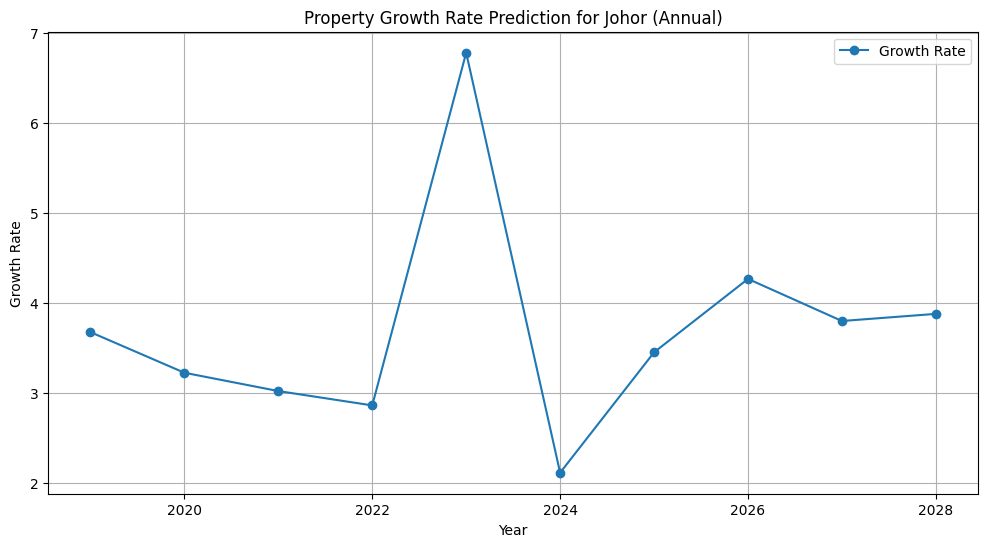

Predicted Growth Rate for 2024: 2.1096
Predicted Growth Rate for 2025: 3.4489
Predicted Growth Rate for 2026: 4.2657
Predicted Growth Rate for 2027: 3.7975
Predicted Growth Rate for 2028: 3.8767


In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(annual_data['Year'], annual_data['Growth Rate'], marker='o', label="Growth Rate")
plt.xlabel("Year")
plt.ylabel("Growth Rate")
plt.legend()
plt.title(f"Property Growth Rate Prediction for {selected_state} (Annual)")
plt.grid(True)
plt.show()


for year in range(2024, 2029):
    growth_rate = annual_data[annual_data['Year'] == year]['Growth Rate'].values
    if len(growth_rate) > 0:
        print(f"Predicted Growth Rate for {year}: {growth_rate[0]:.4f}")

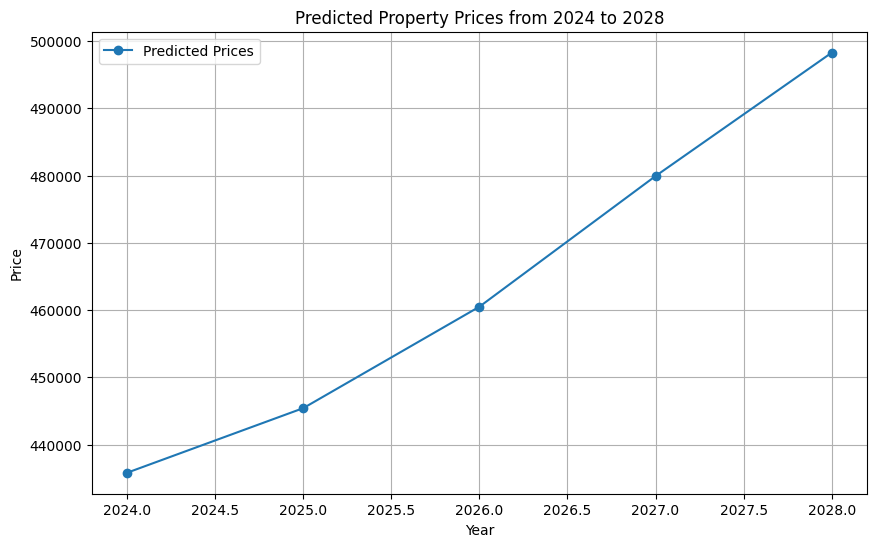

[435812.72, 445415.85200765624, 460498.9690041915, 479926.4995085403, 498266.41076075967]


In [ ]:
import matplotlib.pyplot as plt

# Predicted growth rates from 2024 to 2028
growth_rates = [2.2035, 3.3863, 4.2188, 3.8214, 3.8912]  # In percentage

# Initial price for 2024
initial_price_2024 = predicted_price[0]  # Replace with your actual 2024 price
predicted_prices = [initial_price_2024]  # Initialize the list with the 2024 price

# Calculate prices for 2025-2028 using the growth rates
for rate in growth_rates:
    growth_rate = rate / 100  # Convert percentage to decimal
    next_price = predicted_prices[-1] * (1 + growth_rate)  # Calculate the next year's price
    predicted_prices.append(next_price)

# Now predicted_prices has 6 elements (2024 price + 5 predicted prices)

# Remove the last predicted price to match years up to 2028
predicted_prices = predicted_prices[:-1]  # Now length is 5 (2024 to 2028)

# Prepare years and predicted prices
years = list(range(2024, 2029))  # Years from 2024 to 2028 (inclusive)

# Now both years and predicted_prices have length 5

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(years, predicted_prices, marker='o', label="Predicted Prices")

# Add data labels above each point
#for x, y in zip(years, predicted_prices):
#    plt.text(x, y * 1.01, f"{y:,.2f}", fontsize=9, ha='center')

#plt.ylim(min(predicted_prices) * 0.95, max(predicted_prices) * 1.05)
# Customize the plot
plt.title("Predicted Property Prices from 2024 to 2028")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()
print(predicted_prices)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate model performance on training data (X, Y)
train_predictions = model.predict(X)  # Predict training set
train_predictions = scaler.inverse_transform(train_predictions)  # Reverse normalization
Y_actual = scaler.inverse_transform(Y.reshape(-1, 1))  # Reverse normalization for actual values

mse = mean_squared_error(Y_actual, train_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_actual, train_predictions)
r2 = r2_score(Y_actual, train_predictions)

# Create a table of evaluation metrics
metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R² (Coefficient of Determination)'],
    'Score': [mse, rmse, mae, r2]
}

metrics_df = pd.DataFrame(metrics)

# Print the evaluation metrics table
print("Model Performance on Training Data:")
print(metrics_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Model Performance on Training Data:
                              Metric     Score
0           Mean Squared Error (MSE)  1.335622
1     Root Mean Squared Error (RMSE)  1.155691
2          Mean Absolute Error (MAE)  1.008758
3  R² (Coefficient of Determination)  0.584856


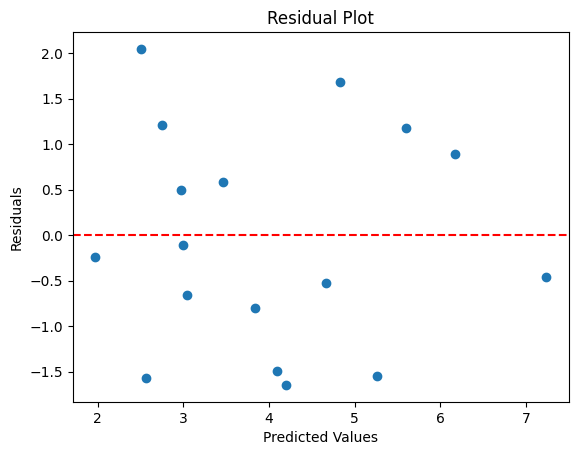

In [ ]:
import matplotlib.pyplot as plt

residuals = Y_actual - train_predictions
plt.scatter(train_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


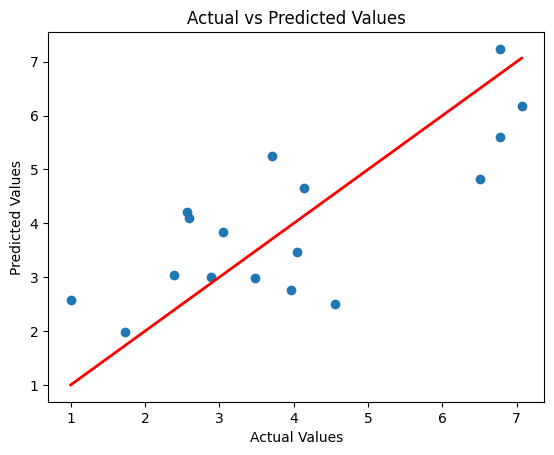

In [ ]:
plt.scatter(Y_actual, train_predictions)
plt.plot([min(Y_actual), max(Y_actual)], [min(Y_actual), max(Y_actual)], color='red', lw=2)  # Perfect fit line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


 'Price', 'btm', 'bdm', 'Size', 'Property Type','Property_description','Location'

In [ ]:
df2.Property_description.unique()

array(['2-storey Terraced House', 'Apartment', 'Flat',
       '1-storey Terraced House', 'Cluster House', 'Service Residence',
       '3-storey Terraced House', 'Condominium',
       '1.5-storey Terraced House', 'Semi-Detached House',
       '2.5-storey Terraced House', 'Terraced House', 'Townhouse',
       'Others', 'Townhouse Condo', 'Bungalow House', 'Studio', 'Duplex',
       'Link Bungalow'], dtype=object)

In [ ]:
df2.Location.unique()

array(['Kulai', 'Johor Bahru', 'Iskandar Puteri', 'Permas Jaya', 'Senai',
       'Tampoi', 'Gelang Patah', 'Skudai', 'Masai', 'Muar',
       'Pasir Gudang', 'Ulu Tiram', 'Setia Indah', 'Setia Tropika',
       'other', 'Perling', 'Kluang', 'Tebrau', 'Batu Pahat',
       'Kota Tinggi', 'Segamat'], dtype=object)

In [ ]:
df2['Property Type'].unique()

array(['House', 'Apartment / Condominium'], dtype=object)